### Import libraries

In [1]:
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import itertools
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

### Change directory to th e.pickle and reead it

In [2]:
#roots 
root_data =  'C:\\Users\\David\\Google Drive\\Alicante'
root_analysis = 'C:\\Users\\David\\Dropbox\\ALICANTE\\plots_fnir'

os.chdir( root_data)
f=open("data_fnir.pickle","rb")
data=np.array(pickle.load(f, encoding='latin1'))

#### Lists with the conditions following the structure of the data

In [3]:
strings=['DIR_CARTAS_C','DIR_CARTAS_NC', 'DIR_CUBILETES_C', 'DIR_CUBILETES_NC', 'DIR_MONEDAS_C', 'DIR_MONEDAS_NC', 'ORD_CARTAS_C', 'ORD_CARTAS_NC', 'ORD_CUBILETES_C', 'ORD_CUBILETES_NC', 'ORD_MONEDAS_C', 'ORD_MONEDAS_NC']
conditions=['d_c_c','d_c_n', 'd_b_c', 'd_b_n', 'd_m_c', 'd_m_n', 'o_c_c', 'o_c_n', 'o_b_c', 'o_b_n', 'o_m_c', 'o_m_n']
c_o_d=['directo', 'directo', 'directo', 'directo', 'directo', 'directo', 'video', 'video', 'video', 'video', 'video', 'video']
c_material=['cartas', 'cartas', 'cubiletes', 'cubiletes', 'monedas', 'monedas', 'cartas', 'cartas', 'cubiletes', 'cubiletes', 'monedas', 'monedas']
c_ncondi=['cond', 'no-cond', 'cond', 'no-cond', 'cond', 'no-cond', 'cond', 'no-cond', 'cond', 'no-cond', 'cond', 'no-cond']

subj_labels = strings_in=[[1,2,5,7,10,11,18,21,26,30,31,32,33,34,39,44,45,51], [3,4,6,8,9,12,13,16,17,22,25,40,41,42,43,46,47,52], [1,2,5,7,11,18,21,26,30,31,32,33,34,39,44,45,51], [3,4,6,8,9,12,13,16,17,22,25,40,41,42,43,46,47,52], [3,4,6,8,9,12,13,16,17,22,25,40,41,42,43,46,47,52], [1,2,5,7,10,11,18,21,26,30,31,32,33,34,39,44,45,51], [14,19,23,28,29,35,38,49,53], [15,20,24,27,36,37,48,50], [15,20,24,27,36,37,48,50], [14,19,23,28,29,35,38,49,53], [15,20,24,27,36,37,48,50], [14,19,23,28,29,35,38,49,53]]
#
label_channel =[ [str(i) + '_s_t', str(i) + '_s_740', str(i) + '_s_860', str(i) + '_l_t', str(i) + '_l_740', str(i) + '_l_860'] for i in range(0,16)]
label_channel = list(itertools.chain.from_iterable(label_channel)) 
colum_matrix = ['time', 'marks', 'baseline'] + label_channel

### Create the DataFrame
#### You substract the biseline value --> Your measure will be increase over the baseline in absolute terms
#### You take the last 15 seconds of baseline
#### You add regressors depending on vison (directo/ordenador), naturaluidad, etc...

In [4]:
frames=[]
for c_idx, cond in enumerate(conditions):
    subj_list = subj_labels[c_idx]
    for idx, subject in enumerate(subj_list):
        ### fataframe of this subject in this condition
        df_s = pd.DataFrame( data[c_idx][idx] )
        df_s.columns = colum_matrix
        ######
        ######
        ######
        ######        
        #### substract_baseline in each subject and condition
        #### (if you do not want this you have to comment)
        # baseline of each channel (when ==1)
        bl_column_mean = df_s.loc[df_s['baseline'] == 1].iloc[-150:].mean(axis=0)
        bl_column_std = df_s.loc[df_s['baseline'] == 1].iloc[-150:].std(axis=0)
        ## df of just recording ==2
        df_2 = df_s.loc[df_s['baseline'] == 2]
        #relative increase over baseline
        #_df_s = (df_2[label_channel] - bl_column_mean[label_channel])/ bl_column_std 
        df_s = df_2[label_channel] - bl_column_mean[label_channel]
        # this columns are the same
        df_s['time'] = df_2['time']
        df_s['marks'] = df_2['marks']   
        df_s['baseline'] = df_2['baseline']
        ######
        ######
        ######
        ######
        # add the subject and the condition (you need this inependently of the baseline substraction)
        df_s['cond'] = cond
        df_s['vision'] = c_o_d[c_idx]
        df_s['material'] = c_material[c_idx]
        df_s['naturalidad'] = c_ncondi[c_idx]
        df_s['subj'] = subject
        frames.append(df_s)
    

df_bl = pd.concat(frames, ignore_index=True)


### Select the SURPRISE time in the df
#### mark == 17 (there are others but I am 100% sure about this one, is the first time they press)
#### As the channels can work differently, Y take 3 seconds before and 3 seconds after they press

In [5]:
##### df of 5 seconds after they click of surprise!
surprise_idx = df_bl.loc[df_bl['marks']==17].index
time_adquisition=10 # 10 frames for second


###plt.plot(df_bl[label_channel_t[8]].iloc[idx-150: idx+25])
t_b = 30
t_a = 30

df_5s=[]
for idx in surprise_idx:
    #df_before_mean =  df_bl.iloc[idx- t_base : idx ][label_channel].mean(axis=0)
    #df_before_std =  df_bl.iloc[idx- t_base : idx ][label_channel].std(axis=0)
    #df_after =  df_bl.iloc[idx-t_res : idx][label_channel] - df_before_mean
    df_after =  df_bl.iloc[idx-t_b : idx + t_a][label_channel] 
    df_after['cond'] = df_bl.iloc[idx-t_b : idx + t_a]['cond']
    df_after['vision'] = df_bl.iloc[idx-t_b : idx + t_a]['vision']
    df_after['material'] = df_bl.iloc[idx-t_b : idx+ t_a]['material']
    df_after['baseline'] = df_bl.iloc[idx-t_b : idx+ t_a]['baseline']
    df_after['naturalidad'] = df_bl.iloc[idx-t_b : idx+ t_a]['naturalidad']
    df_after['subj'] = df_bl.iloc[idx-t_b : idx+ t_a]['subj']
    df_5s.append( df_after ) ## df_bl.iloc[idx-50 : idx + 50]

        
##### 5 seconds after they click, normalized by baseline!
df_5s = pd.concat(df_5s, ignore_index=True)

#### Labels of the channels (for the plots)

In [39]:
label_channel_s_740 =[ str(i) + '_s_740' for i in range(0,16)] 
label_channel_l_740 =[ str(i) + '_l_740' for i in range(0,16)] 
label_channel_s_860 =[ str(i) + '_s_860' for i in range(0,16)] 
label_channel_l_860 =[ str(i) + '_l_860' for i in range(0,16)] 
label_channel_s_t =[ str(i) + '_s_t' for i in range(0,16)] 
label_channel_l_t =[ str(i) + '_l_t' for i in range(0,16)] 


## Plot to see the channels activity (after you run the following cell)
# for i in range(0,16):
#     plt.plot(df_bl[label_channel_s_740[i]].iloc[idx-150: idx+25], 'b')
#     plt.plot(df_bl[label_channel_l_740[i]].iloc[idx-150: idx+25], 'g')
#     plt.plot(df_bl[label_channel_s_860[i]].iloc[idx-150: idx+25], 'r')
#     plt.plot(df_bl[label_channel_l_860[i]].iloc[idx-150: idx+25], 'k')
#     plt.show()


    

### Short distance of the channel
#### The substracton 860 - 740  reflect the ncrease of oxigenation in the vascularization (HbO - Hbdesox)

### Plot the comparisions

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


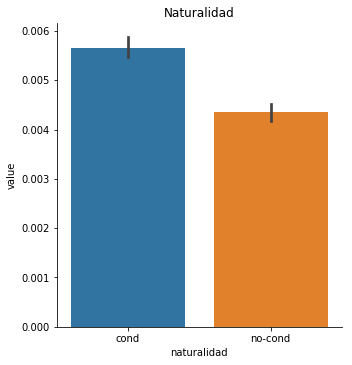

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


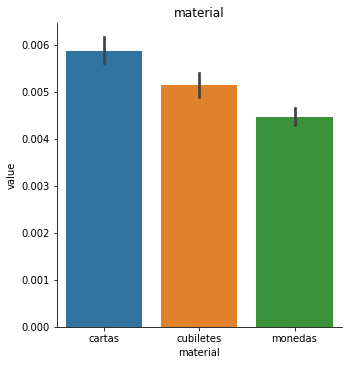

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


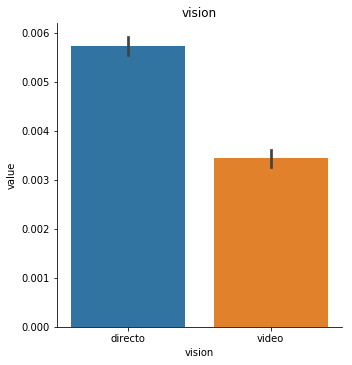

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


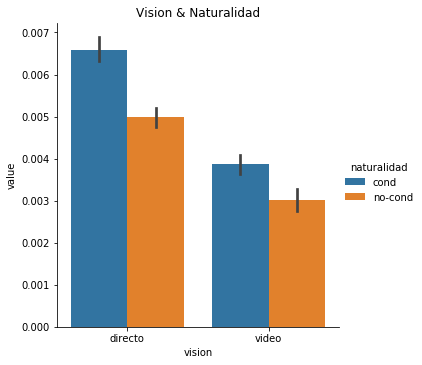

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


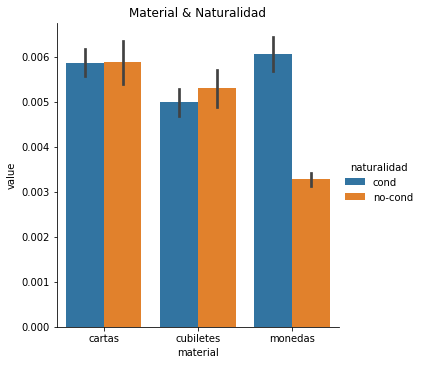

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


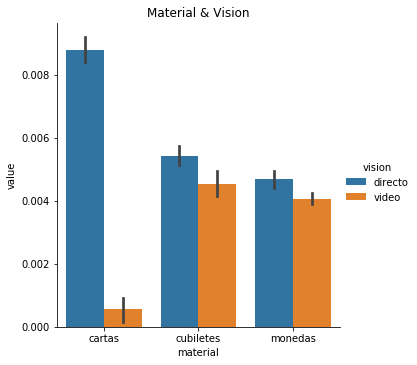

In [34]:
#### Naturalidad
df_5s_nat = pd.melt(df_5s, id_vars='naturalidad', value_vars =label_channel_s_740 )
   
#### Material
df_5s_mat = pd.melt(df_5s, id_vars='material', value_vars =label_channel_s_740 )

#### visionado
df_5s_vis = pd.melt(df_5s, id_vars='vision', value_vars =label_channel_s_740 )

### all together in df_5
df_5s_subj = pd.melt(df_5s, id_vars='subj', value_vars =label_channel_s_740 )
df_5s_860 = pd.melt(df_5s, id_vars='naturalidad', value_vars =label_channel_s_860 ) 
## 860 - 740 to analyze!
value = df_5s_860['value'] - df_5s_vis['value']
df_5 = df_5s_vis.copy()
df_5['value'] = value
df_5['material'] = df_5s_mat['material']
df_5['naturalidad'] = df_5s_nat['naturalidad']
df_5['subj'] = df_5s_subj['subj']

######################### Plots ##############################

sns.factorplot(x='naturalidad', y='value', data=df_5, kind='bar' )
plt.title('Naturalidad')
plt.show(block=False)

sns.factorplot(x='material', y='value', data=df_5, kind='bar' )
plt.title('material')
plt.show(block=False)

sns.factorplot(x='vision', y='value', data=df_5, kind='bar' )
plt.title('vision')
plt.show(block=False)

######

sns.factorplot(x='vision', y='value', hue='naturalidad', data=df_5, kind='bar' )
plt.title('Vision & Naturalidad')
plt.show(block=False)

sns.factorplot(x='material', y='value', hue='naturalidad', data=df_5, kind='bar' )
plt.title('Material & Naturalidad')
plt.show(block=False)

sns.factorplot(x='material', y='value', hue='vision', data=df_5, kind='bar' )
plt.title('Material & Vision')
plt.show(block=False)


### Long distance of the channel
#### The substracton 860 - 740  reflect the ncrease of oxigenation in PFC (HbO - Hbdesox)

### Plot the comparisions

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


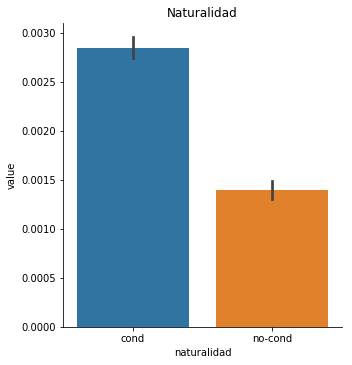

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


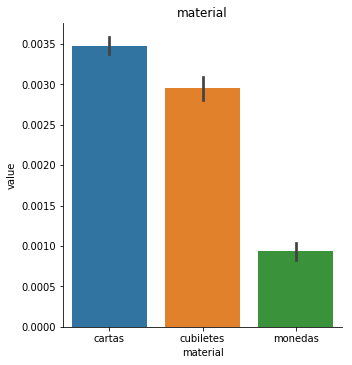

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


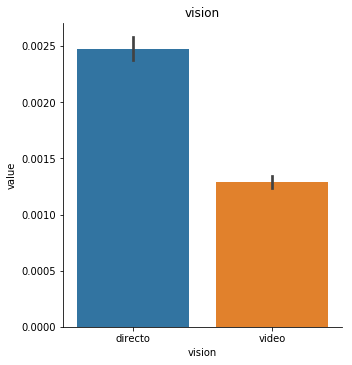

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


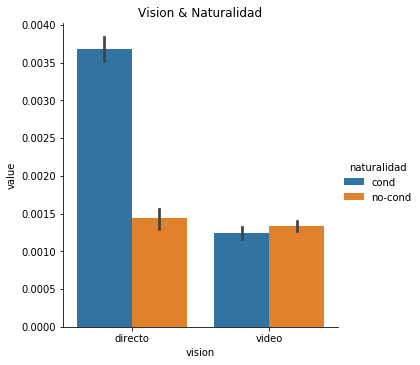

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


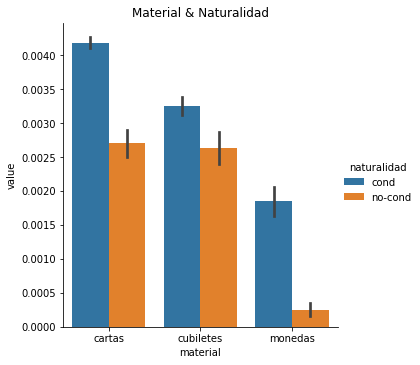

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


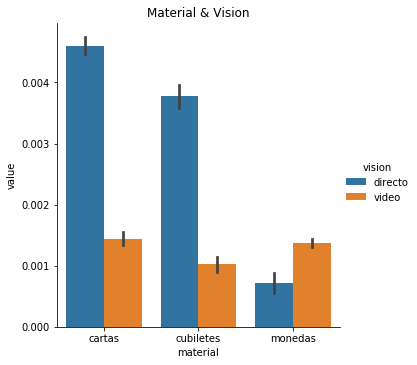

In [30]:
#### Naturalidad
df_5s_nat = pd.melt(df_5s, id_vars='naturalidad', value_vars =label_channel_l_740 )
   
#### Material
df_5s_mat = pd.melt(df_5s, id_vars='material', value_vars =label_channel_l_740 )

#### visionado
df_5s_vis = pd.melt(df_5s, id_vars='vision', value_vars =label_channel_l_740 )

### all together in df_5
df_5s_subj = pd.melt(df_5s, id_vars='subj', value_vars =label_channel_l_740 )
df_5s_860 = pd.melt(df_5s, id_vars='naturalidad', value_vars =label_channel_l_860 ) 
## 860 - 740 to analyze!
value = df_5s_860['value'] - df_5s_vis['value']
df_5_l = df_5s_vis.copy()
df_5_l['value'] = value
df_5_l['material'] = df_5s_mat['material']
df_5_l['naturalidad'] = df_5s_nat['naturalidad']
df_5_l['subj'] = df_5s_subj['subj']

######################### Plots ##############################

sns.factorplot(x='naturalidad', y='value', data=df_5_l, kind='bar' )
plt.title('Naturalidad')
plt.show(block=False)

sns.factorplot(x='material', y='value', data=df_5_l, kind='bar' )
plt.title('material')
plt.show(block=False)

sns.factorplot(x='vision', y='value', data=df_5_l, kind='bar' )
plt.title('vision')
plt.show(block=False)

######

sns.factorplot(x='vision', y='value', hue='naturalidad', data=df_5_l, kind='bar' )
plt.title('Vision & Naturalidad')
plt.show(block=False)

sns.factorplot(x='material', y='value', hue='naturalidad', data=df_5_l, kind='bar' )
plt.title('Material & Naturalidad')
plt.show(block=False)

sns.factorplot(x='material', y='value', hue='vision', data=df_5_l, kind='bar' )
plt.title('Material & Vision')
plt.show(block=False)
